# 1 - Problem Statement

TODO

# 2 - Scraping Data

In [21]:
# imports
import os
import time
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [22]:
# These dictionaries are used to convert the event 
# and year into the codes used in the url
event_dict = {
    "mile": "57",
    "3000m": "60",
    "5000m": "62",
}

year_dict = {
    "2022_2023": "3901",
    "2021_2022": "3492",
    "2020_2021": "3157",
    "2019_2020": "2770",
    "2018_2019": "2324",
    "2017_2018": "2124",
    "2016_2017": "1797",
}

In [23]:
# helper function to convert html row into dictionaries
# for easy transformation into dataframe
def row_to_dictionary(row, column_names):
    """
    Description:
        helper function to convert html row into dictionaries
        for easy transformation into dataframe

    args:
        row: html row from beautiful soup eg. ds.select("tbody tr")[0]
        column_names: list of column names eg. ["Rank", "Name", "Year", "School", "Performance"]
    """
    row_items = [item.text.strip() for item in row.select("td")]
    return dict(zip(column_names, row_items))


def fetch_table(event, year_range, gender):
    """
    Description:
        fetches the html table from tfrrs.org and converts it into a dataframe
        for the given event, year, and gender. Only gets top 50 performances.
        Note: only scrapes indoor performances, not outdoor
    args:
        event: string, event name eg. "mile" or "3000m"
        year_range: string, year range eg. "2022_2023"
        gender: string, "m" or "f"
    """
    # modify url and table tag for event, gender, and year
    url = f"https://tf.tfrrs.org/lists/{year_dict[year_range]}/{year_range}_NCAA_Div_I_Indoor_Qualifying_FINAL?gender={gender}"
    table_tag = f"div.row.gender_{gender}.standard_event_hnd_{event_dict[event]}"

    # performance list urls
    snapshot_url = url
    headers = {"User-Agent": "Mozilla/5.0"}
    snapshot_response = requests.get(snapshot_url, headers=headers)
    status_code = snapshot_response.status_code
    
    # check that the page is valid
    assert status_code == 200, f"Error: status code {status_code} for {snapshot_url}"

    # fetch the html and make it soupy
    performance_list = BeautifulSoup(snapshot_response.text, "html.parser")

    # select the event tag
    ds = performance_list.select_one(table_tag)

    # access column names
    columns = [
        item.text.replace(" ", "_") for item in ds.select_one("thead").select("th")
    ]

    # put in new column name for rank
    columns[0] = "Rank"

    # create dataframe of performances
    return pd.DataFrame(
        [row_to_dictionary(row, columns) for row in ds.select("tbody tr")]
    )
    
def time_to_sec(t):
    """
    Description: convert time string to seconds
        remove any weird symbols eg. @, #, \n
    """    
    t = t.strip("\n@\n#")
    m, s = t.split(':')
    return int(m) * 60 + float(s)

def preprocess(df):
    """
    Description: preprocess dataframe
        - convert time to seconds
    """
    df["Time_seconds"] = df['Time'].apply(time_to_sec)
    return df

In [24]:
# data directory
save_dir = "data/"

# Create a new directory if it doesnt exist
if not os.path.exists(save_dir):
   os.makedirs(save_dir)
   
# loop through events, genders, and years
for gender in ["m", "f"]:
    for event in event_dict.keys():
        for year_range in year_dict.keys():
            file = f"{save_dir}{year_range}_{event}_{gender}.csv"
            # skip if file already exists
            if os.path.exists(file):
                continue
            df = preprocess(fetch_table(event, year_range, gender))
            df.to_csv(file, index=False)
            print(f"Saved {file}")
            time.sleep(1)

# 3 - Exploratory Data Analysis

In [25]:
from itertools import product
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [26]:
events = ["mile", "3000m", "5000m"]
gender = ["f", "m"]
years = list(np.arange(2016, 2023, 1))

combinations = list(product(events, gender, years))

# preprocess and concatenate data from all genders, events, and years
for event, gender, year in combinations:
    temp = pd.read_csv(f"data/{year}_{year+1}_{event}_{gender}.csv")
    # one-hot encode gender
    temp["gender"] = 0 if gender == "f" else 1

    # infer whether supershoes were worn based on year
    # (Nike Dragonfly released in Aug 2020)
    temp["supershoes"] = 1 if year >= 2021 else 0

    # maintain ordinal value for year (may need to scale later)
    temp["year"] = int(year)
    temp["yearOrdinal"] = int(year-2015)

    # add event column
    temp["event"] = event

    if year == 2016 and gender == "f" and event == "mile":
        data = temp
    else:
        data = pd.concat([data, temp], sort=False)

# Assign ordinal values to class year?
# fill NAN values with another class. 5 = other. 
# Typically this happens because of a redshirt season or later injury
# only happens for 6 people in whole dataset
data = data.rename(columns={"Year": "ClassYear"})
data["ClassYear"] = data["ClassYear"].str[0:2].map({"FR": 1, "SO": 2, "JR": 3, "SR": 4})
data["ClassYear"] = data["ClassYear"].fillna(5)

data["dummy"] = data["event"]
# add dummy variables for event
data = pd.get_dummies(data, columns=["dummy"])

In [41]:
data.columns

Index(['Rank', 'Athlete', 'ClassYear', 'Team', 'Time', 'Meet', 'Meet_Date',
       'Time_seconds', 'gender', 'supershoes', 'year', 'yearOrdinal', 'event',
       'dummy_3000m', 'dummy_5000m', 'dummy_mile', 'Last Name', 'First Name'],
      dtype='object')

In [27]:
data.describe()

,Rank,ClassYear,Time_seconds,gender,supershoes,year,yearOrdinal
count,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000
mean,35.347719,2.907018,556.528189,0.500000,0.210526,2018.736842,3.736842
std,20.968063,1.018667,266.347979,0.500088,0.407754,1.915431,1.915431
min,1.000000,1.000000,230.390000,0.000000,0.000000,2016.000000,1.000000
25%,17.000000,2.000000,278.912500,0.000000,0.000000,2017.000000,2.000000
50%,34.000000,3.000000,501.380000,0.500000,0.000000,2019.000000,4.000000
75%,52.000000,4.000000,832.245000,1.000000,0.000000,2020.000000,5.000000
max,75.000000,5.000000,1004.970000,1.000000,1.000000,2022.000000,7.000000


In [28]:
data.head()

,Rank,Athlete,ClassYear,Team,Time,Meet,Meet_Date,Time_seconds,gender,supershoes,year,yearOrdinal,event,dummy_3000m,dummy_5000m,dummy_mile
0,1,"Edwards, Kaela",4.0,Oklahoma State,4:28.75,110th NYRR Millrose Games,"Feb 11, 2017",268.75,0,0,2016,1,mile,False,False,True
1,2,"Purrier, Elinor",3.0,New Hampshire,4:29.44,110th NYRR Millrose Games,"Feb 11, 2017",269.44,0,0,2016,1,mile,False,False,True
2,3,"Rivers, Danae",1.0,Penn State,4:32.55,2017 Husky Classic,"Feb 10, 2017",272.55,0,0,2016,1,mile,False,False,True
3,4,"Jones, Dani",2.0,Colorado,4:32.68\n@,Colorado Open,"Feb 2, 2017",272.68,0,0,2016,1,mile,False,False,True
4,5,"Cleirigh Buttner, Siofra",3.0,Villanova,4:33.16,Fastrack National Invite,"Feb 10, 2017",273.16,0,0,2016,1,mile,False,False,True


In [29]:
mile_data = data[data['dummy_mile'] == True ] 
m3000m_data = data[data['dummy_3000m'] == True]
m5000m_data = data[data['dummy_5000m'] == True]

events = [('Mile', mile_data), ('3000m', m3000m_data), ('5000m', m5000m_data)]

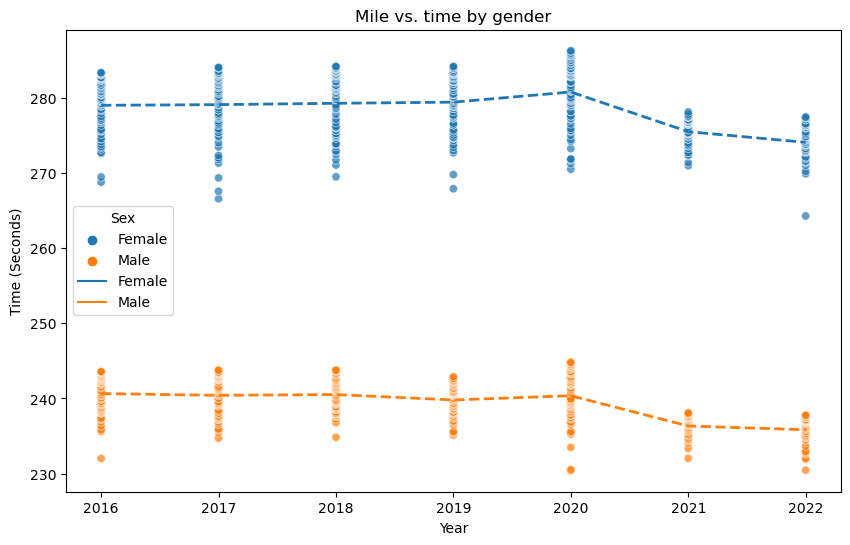

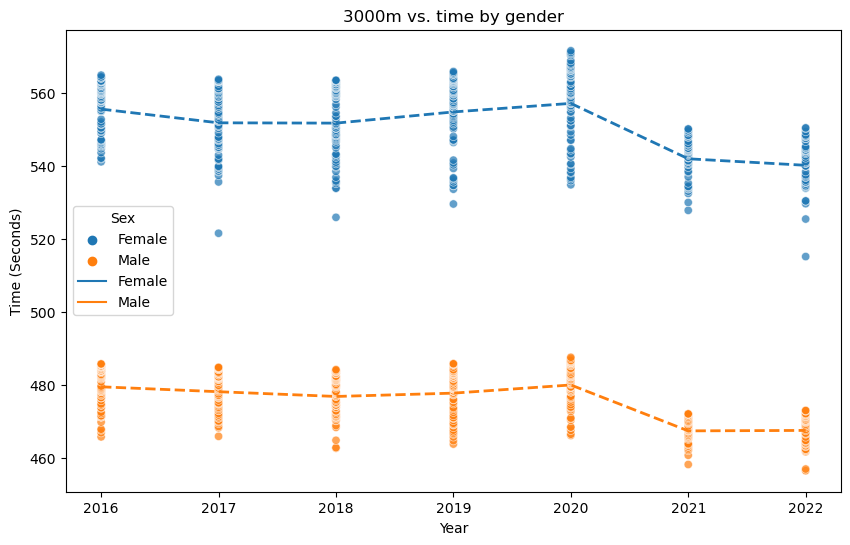

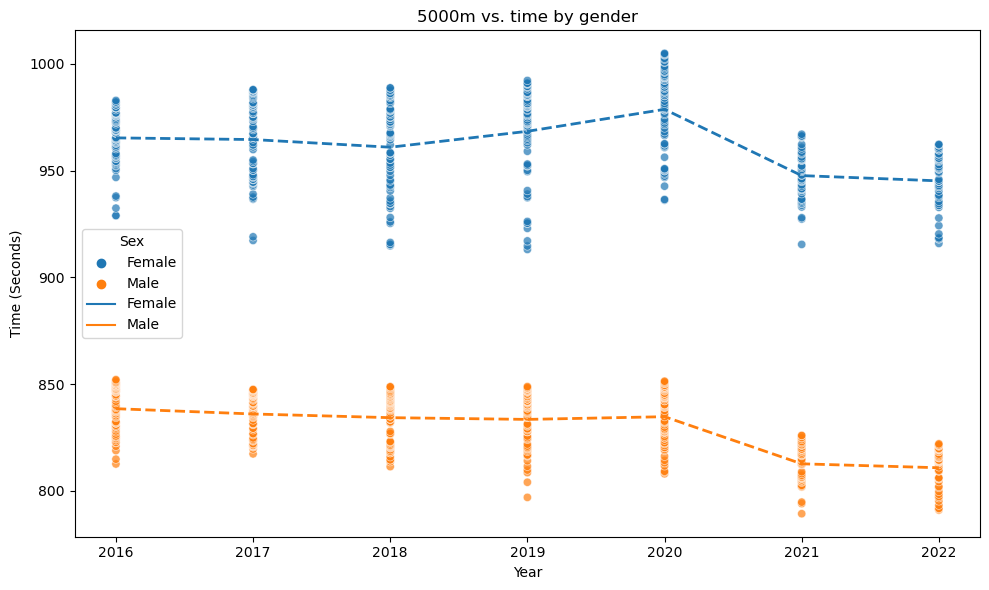

In [30]:
for event, event_data in events:
    plt.figure(figsize=(10, 6)) 
    
    # Scatter plot for both genders
    plot = sns.scatterplot(data=event_data, x='year', y='Time_seconds', hue='gender', alpha=0.7)
    sns.lineplot(data=event_data, x='year', y='Time_seconds', hue='gender', estimator='mean', ci=None, linestyle='--', linewidth=2)
    
    plt.xlabel('Year')
    plt.ylabel('Time (Seconds)')
    plt.title(f'{event} vs. time by gender')

    plot.legend_.texts[1].set_text('Male')
    plot.legend_.texts[0].set_text('Female')
    plot.legend_.texts[3].set_text('Male')
    plot.legend_.texts[2].set_text('Female')
    plot.legend_.set_title('Sex')
    
plt.tight_layout() 

In [31]:
# I wanted to look at duplicates of one person
data[['Last Name', 'First Name']] = data['Athlete'].str.split(', ', expand=True)

name_counts = data['Athlete'].value_counts()

print(name_counts)

Athlete
Kemboi, Amon         12
Gregory, Lauren      11
Hasz, Bethany        11
Logue, Cailie        10
Monson, Alicia       10
                     ..
Koekemoer, Travis     1
Mills, Ethan          1
Schroff, Andrew       1
Addison, Evan         1
Kiprop, Victor        1
Name: count, Length: 1249, dtype: int64


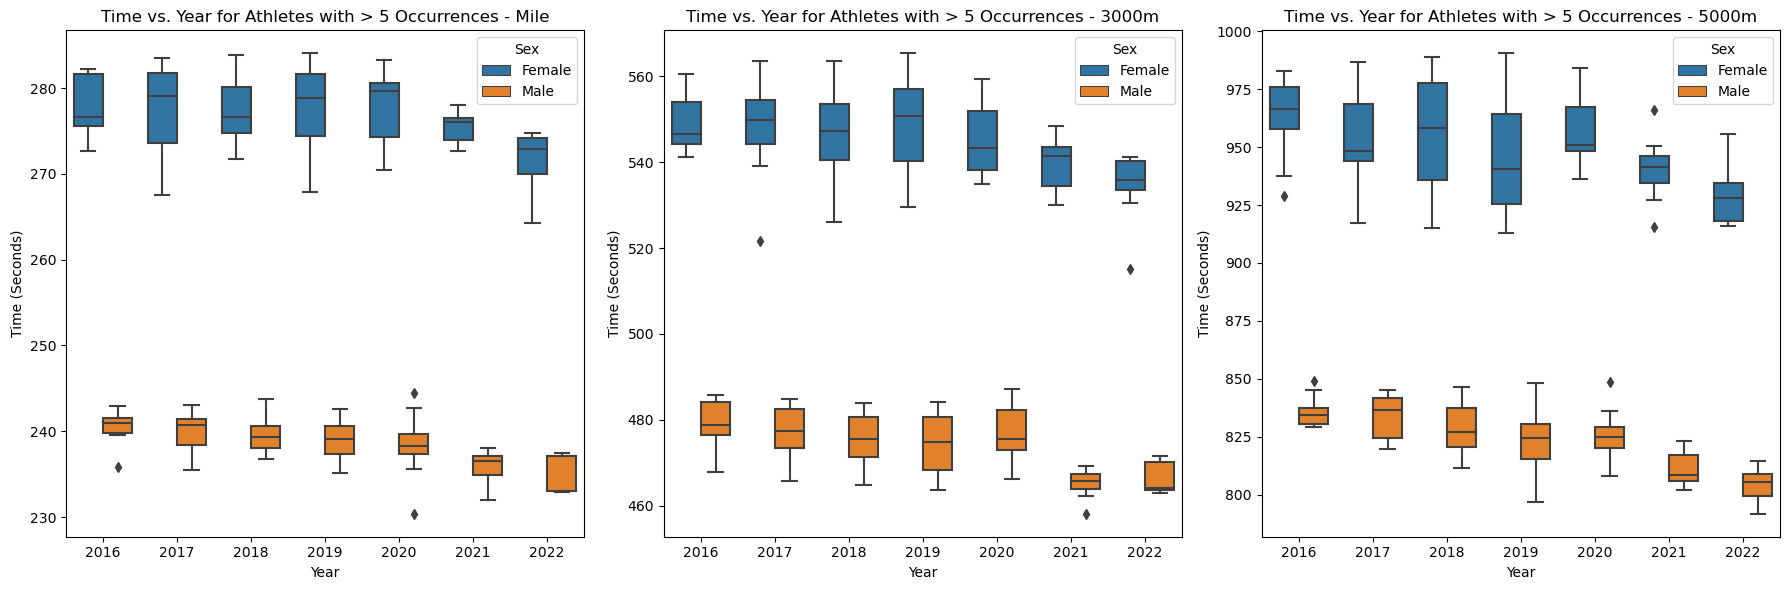

In [32]:
# Filter names with more than 5 occurrences
popular_names = name_counts[name_counts > 5].index
popular_names_data = data[data['Athlete'].isin(popular_names)]

# Define events and corresponding data
mile_data = popular_names_data[popular_names_data['dummy_mile']]
m3000m_data = popular_names_data[popular_names_data['dummy_3000m']]
m5000m_data = popular_names_data[popular_names_data['dummy_5000m']]

events = [('Mile', mile_data), ('3000m', m3000m_data), ('5000m', m5000m_data)]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (event, event_data) in zip(axes, events):
    plot = sns.boxplot(data=event_data, x='year', y='Time_seconds', hue='gender', ax=ax)

    plot.set_xlabel('Year')
    plot.set_ylabel('Time (Seconds)')
    plot.set_title(f'Time vs. Year for Athletes with > 5 Occurrences - {event}')
    plot.legend_.texts[1].set_text('Male')
    plot.legend_.texts[0].set_text('Female')
    plot.legend_.set_title('Sex')


plt.tight_layout()
plt.show()

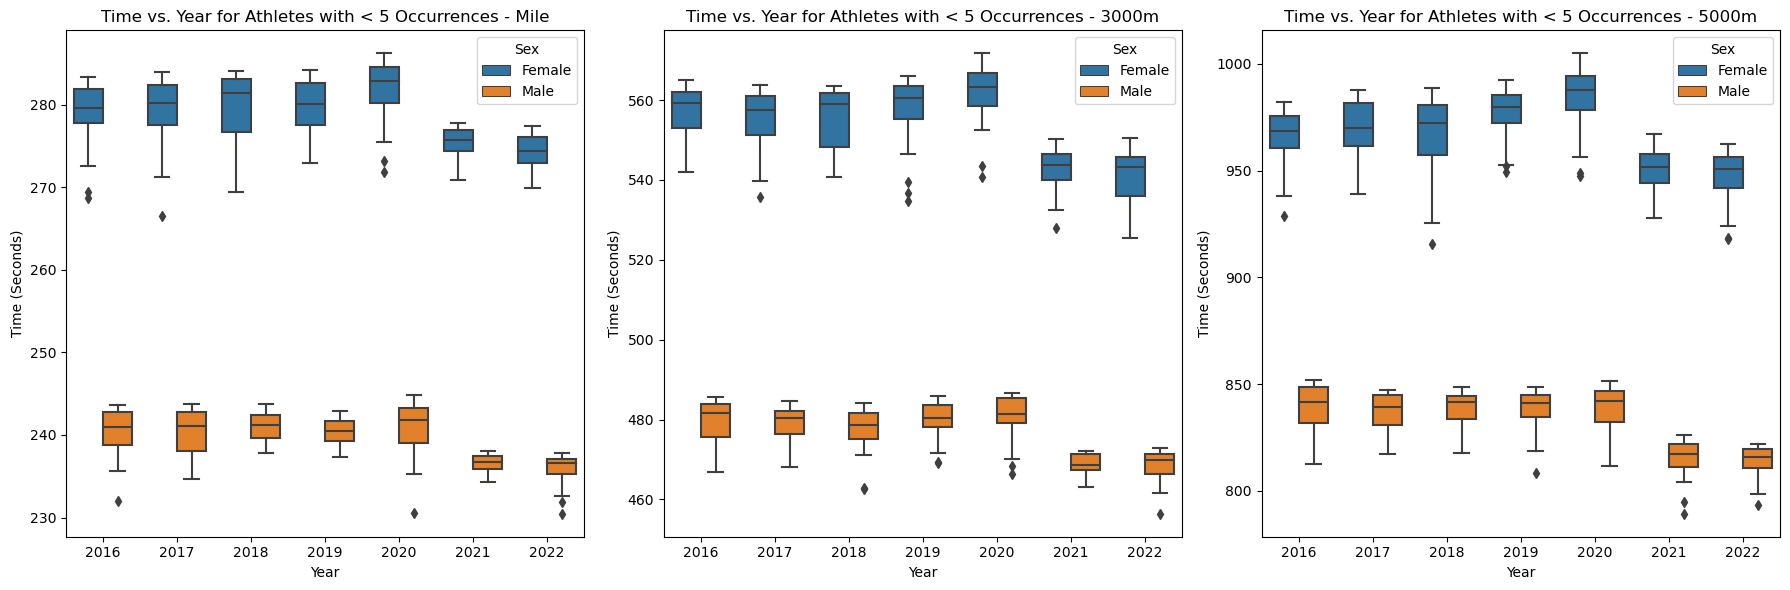

In [33]:
# Filter names with less than 5 occurrences
unpopular_names = name_counts[name_counts < 5].index
unpopular_names_data = data[data['Athlete'].isin(unpopular_names)]

mile_data = unpopular_names_data[unpopular_names_data['dummy_mile']]
m3000m_data = unpopular_names_data[unpopular_names_data['dummy_3000m']]
m5000m_data = unpopular_names_data[unpopular_names_data['dummy_5000m']]

events = [('Mile', mile_data), ('3000m', m3000m_data), ('5000m', m5000m_data)]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (event, event_data) in zip(axes, events):
    plot = sns.boxplot(data=event_data, x='year', y='Time_seconds', hue='gender', ax=ax)

    plot.set_xlabel('Year')
    plot.set_ylabel('Time (Seconds)')
    plot.set_title(f'Time vs. Year for Athletes with < 5 Occurrences - {event}')
    plot.legend_.texts[1].set_text('Male')
    plot.legend_.texts[0].set_text('Female')
    plot.legend_.set_title('Sex')


plt.tight_layout()
plt.show()

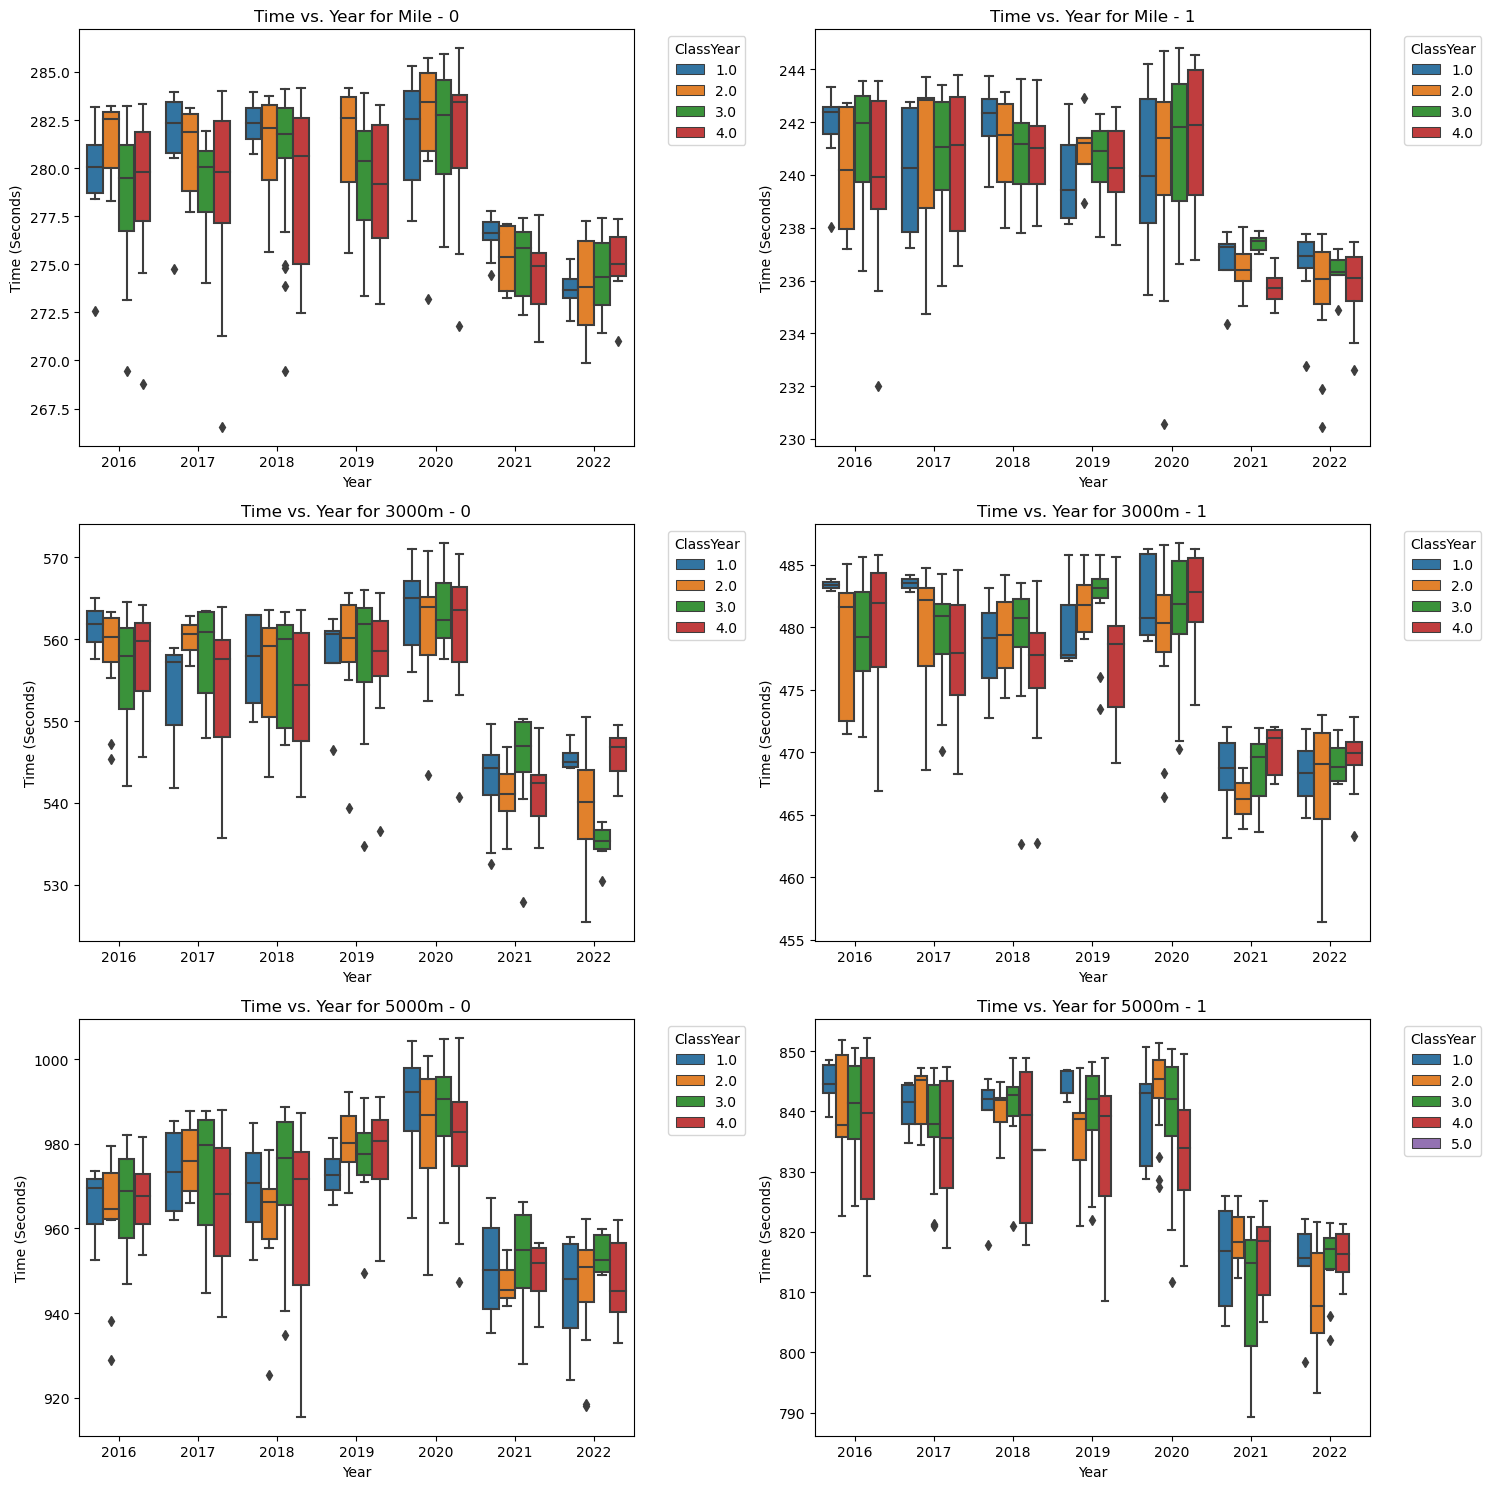

In [34]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, (event, event_data) in enumerate(events):
    for j, gender in enumerate([0, 1]):
        # Filter data for the current event and gender
        gender_data = event_data[event_data['gender'] == gender]
        

        sns.boxplot(x='year', y='Time_seconds', hue='ClassYear', data=gender_data, ax=axes[i * 2 + j])
        
        axes[i * 2 + j].set_xlabel('Year')
        axes[i * 2 + j].set_ylabel('Time (Seconds)')
        axes[i * 2 + j].set_title(f'Time vs. Year for {event} - {gender}')

        axes[i * 2 + j].legend(title='ClassYear', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()

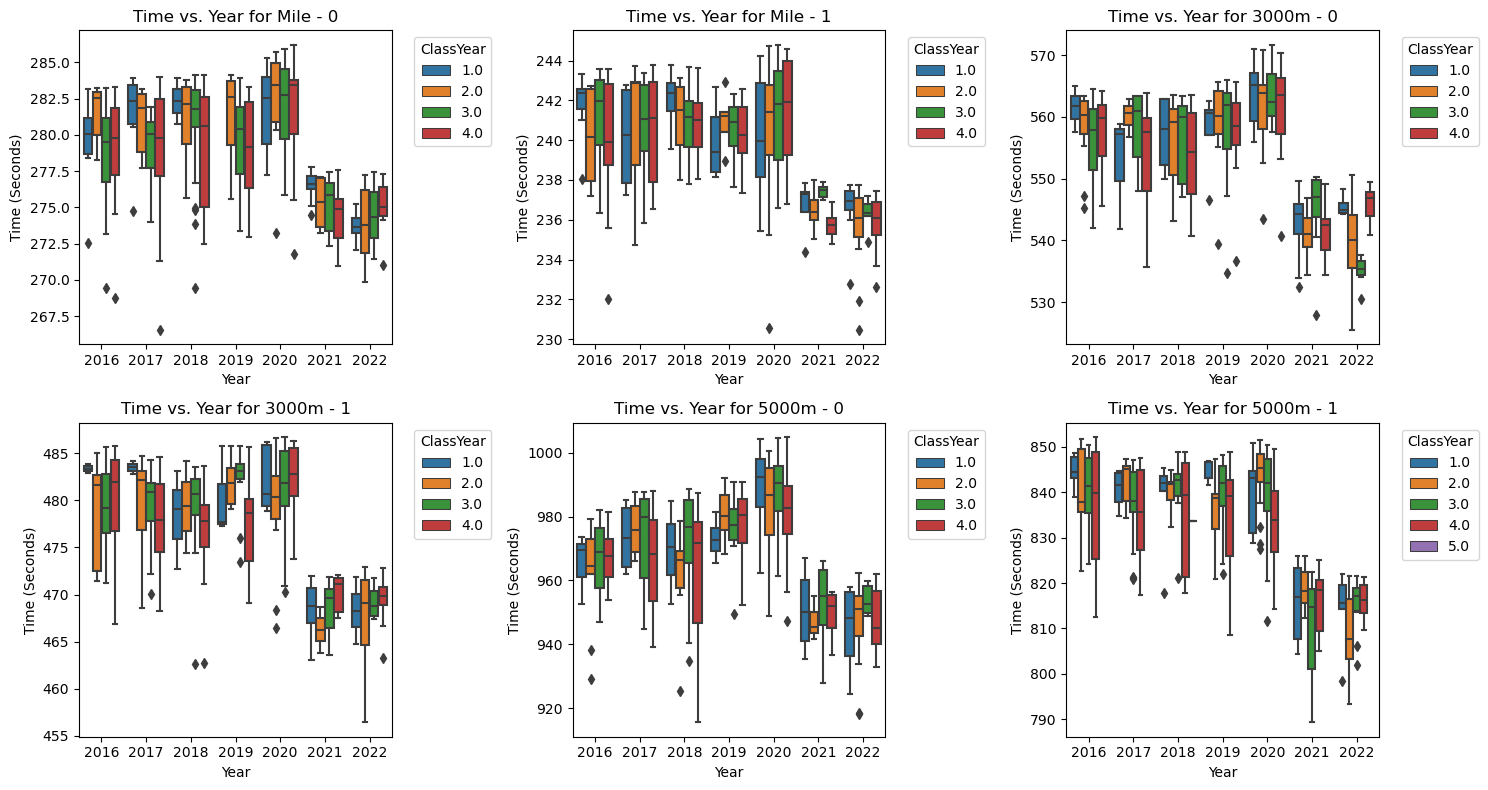

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (event, event_data) in enumerate(events):
    for j, gender in enumerate([0, 1]):
        # Filter data for the current event and gender
        gender_data = event_data[event_data['gender'] == gender]
        

        sns.boxplot(x='year', y='Time_seconds', hue='ClassYear', data=gender_data, ax=axes[i * 2 + j])
        
        axes[i * 2 + j].set_xlabel('Year')
        axes[i * 2 + j].set_ylabel('Time (Seconds)')
        axes[i * 2 + j].set_title(f'Time vs. Year for {event} - {gender}')

        axes[i * 2 + j].legend(title='ClassYear', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()

In [36]:
data_top50 = data[data.Rank <= 50].copy()
data_top50['thirds'] = [0 if rank <= 16 else 1 if (rank > 16)&(rank<=33) else 2 for rank in data_top50.Rank]

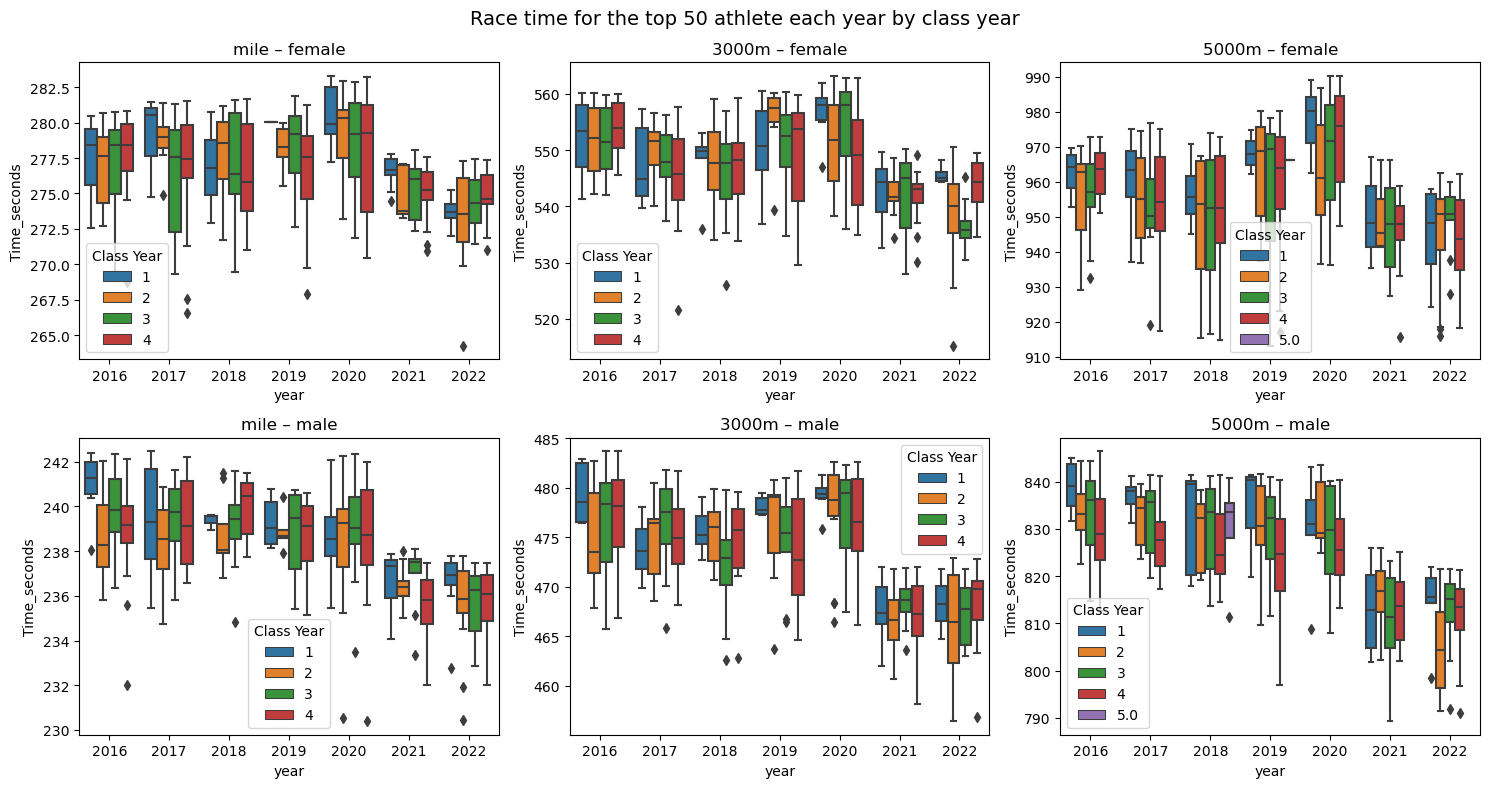

In [37]:
fig, axs = plt.subplots(2,3, figsize=(15,8))
axs = axs.ravel()

for gender in [0,1]:
    for i,event in enumerate(data.event.unique()):
        ax = axs[i+3*gender]
        sns.boxplot(data=data_top50[(data_top50.event==event) & (data_top50.gender==gender)], x='year', y='Time_seconds', hue='ClassYear', ax=ax)

        if gender==0:
            ax.set_title(event+' – female')
        else:
            ax.set_title(event+' – male')

        ax.legend_.set_title('Class Year')
        ax.legend_.texts[0].set_text('1')
        ax.legend_.texts[1].set_text('2')
        ax.legend_.texts[2].set_text('3')
        ax.legend_.texts[3].set_text('4')

plt.suptitle('Race time for the top 50 athlete each year by class year', fontsize=14)
plt.tight_layout()
# plt.savefig('classyear.png', dpi=600)

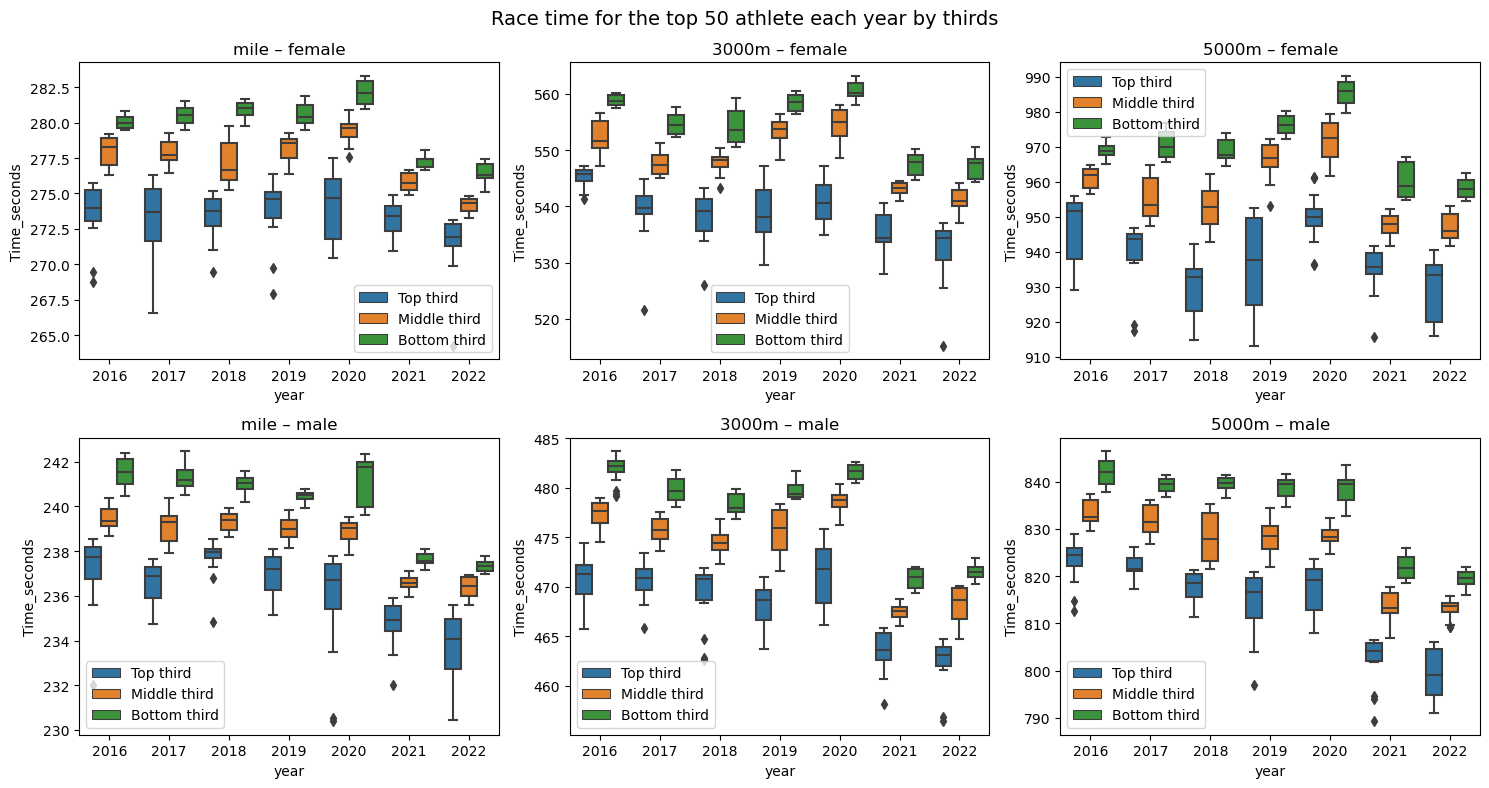

In [38]:
fig, axs = plt.subplots(2,3, figsize=(15,8))
axs = axs.ravel()

for gender in [0,1]:
    for i,event in enumerate(data.event.unique()):
        ax = axs[i+3*gender]
        sns.boxplot(data=data_top50[(data_top50.event==event) & (data_top50.gender==gender)], x='year', y='Time_seconds', hue='thirds', ax=ax)

        if gender==0:
            ax.set_title(event+' – female')
        else:
            ax.set_title(event+' – male')

        ax.legend_.set_title('')
        ax.legend_.texts[0].set_text('Top third')
        ax.legend_.texts[1].set_text('Middle third')
        ax.legend_.texts[2].set_text('Bottom third')

plt.suptitle('Race time for the top 50 athlete each year by thirds', fontsize=14)
plt.tight_layout()
#plt.savefig('thirds.png', dpi=600)

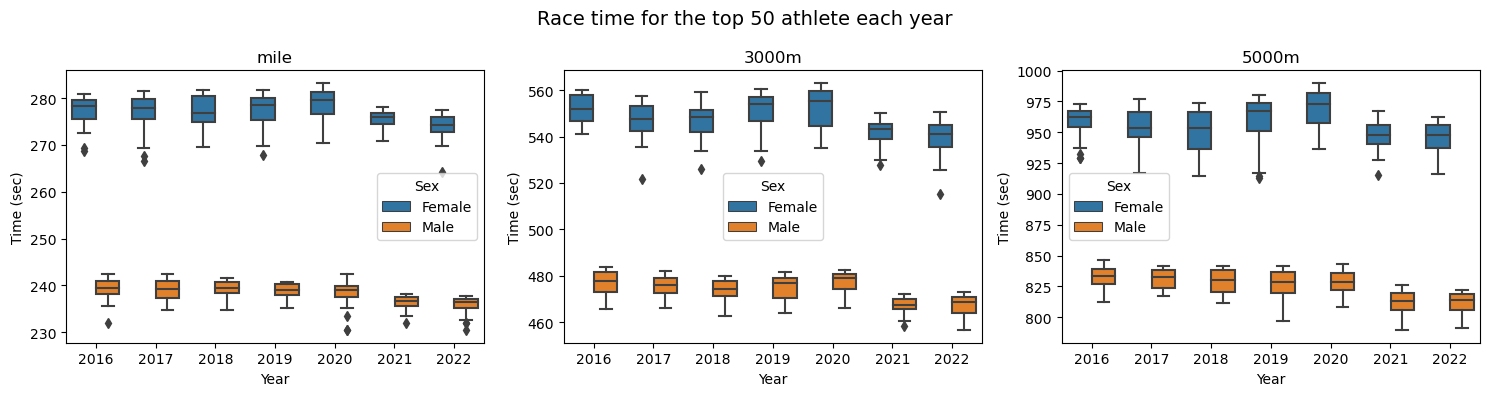

In [39]:
fig, axs = plt.subplots(1,3, figsize=(15,4))

for ax,event in zip(axs,data.event.unique()):
    sns.boxplot(data=data_top50[data_top50.event==event], x='year', y='Time_seconds', hue='gender', ax=ax)

    ax.set_title(event)
    ax.set_xlabel('Year')
    ax.set_ylabel('Time (sec)')
    ax.legend_.set_title('Sex')
    ax.legend_.texts[0].set_text('Female')
    ax.legend_.texts[1].set_text('Male')

plt.suptitle('Race time for the top 50 athlete each year', fontsize=14)
plt.tight_layout()
#plt.savefig('times.png', dpi=600)

# 4 - Model Building

## 4.1 Linear Regression

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [72]:
# helper function to build eqn string and save supershoe coefficients
def build_eqn(model, cols, supershoe_coefs=[]):
    eqn = f"{np.round(model.intercept_, 3)} + "
    for coef, col in zip(model.coef_, cols):
        if col == "supershoes": supershoe_coefs.append(coef)
        eqn += f"({np.round(coef, 3)})*{col} + "
    return eqn[:-2], supershoe_coefs

# Linear Regression
# only fit on relevant columns for x data
print(f"Linear fit results for all predictors:")
temp = data
x_cols = [
    "dummy_5000m",
    "dummy_3000m",
    "dummy_mile", 
    "gender",
    "supershoes",
    "yearOrdinal",
    "Rank",
    "ClassYear",
]
x = temp[x_cols]
y = temp["Time_seconds"]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1)

# create linear regression model
model = LinearRegression().fit(x_train, y_train)
print(f"R^2 test: {model.score(x_test, y_test)}")
eqn, _ = build_eqn(model, x_cols)
print(f"Equation: Time_seconds = {eqn}")
print(f"Test MSE: {mean_squared_error(y_test, model.predict(x_test))}")

Linear fit results for all predictors:
R^2 test: 0.9942558918490598
Equation: Time_seconds = 585.845 + (340.203)*dummy_5000m + (-42.434)*dummy_3000m + (-297.769)*dummy_mile + (-82.311)*gender + (-10.371)*supershoes + (0.517)*yearOrdinal + (0.367)*Rank + (-0.366)*ClassYear 
Test MSE: 415.0415286777636



Event: dummy_mile linear fit results:
R^2: 0.9099715959158883
Equation for gender 0: Time_seconds = 272.427 + (-4.064)*supershoes + (0.36)*yearOrdinal + (0.162)*Rank + (-0.047)*ClassYear 
MSE: 1.6738743465210317
R^2: 0.9525695860780151
Equation for gender 1: Time_seconds = 236.741 + (-2.378)*supershoes + (-0.153)*yearOrdinal + (0.109)*Rank + (-0.032)*ClassYear 
MSE: 0.3635745237361269

Event: dummy_3000m linear fit results:
R^2: 0.9337418136703483
Equation for gender 0: Time_seconds = 538.038 + (-10.144)*supershoes + (0.545)*yearOrdinal + (0.401)*Rank + (-0.168)*ClassYear 
MSE: 6.099529720968355
R^2: 0.9443902638832835
Equation for gender 1: Time_seconds = 469.149 + (-8.291)*supershoes + (0.077)*yearOrdinal + (0.245)*Rank + (-0.075)*ClassYear 
MSE: 2.4069194434388677

Event: dummy_5000m linear fit results:
R^2: 0.8912392023237061
Equation for gender 0: Time_seconds = 929.531 + (-21.414)*supershoes + (2.95)*yearOrdinal + (0.798)*Rank + (-0.399)*ClassYear 
MSE: 38.51502769422227
R^2: 0.

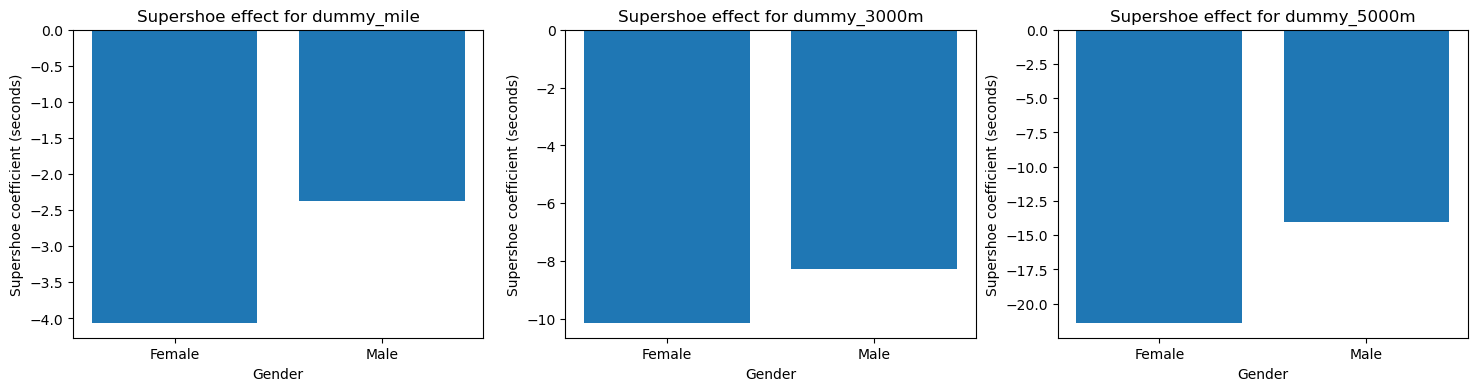

In [74]:
# Here we separate the equations by gender and event to see 
# if there are differences in the effect of supershoes across 
# events or genders
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
events = ["dummy_mile", "dummy_3000m", "dummy_5000m"]
for event, ax in zip(events, axs):
    print(f"\nEvent: {event} linear fit results:")
    supershoe_coefs = []
    for gender in [0, 1]:
        x_cols = [
            "supershoes",
            "yearOrdinal",
            "Rank",
            "ClassYear",
        ]
        x_temp = x_train[x_cols]
        x_temp = x_temp[(x_train[event] == True) & (x_train["gender"] == gender)]
        y_temp = y_train[(x_train[event] == True) & (x_train["gender"] == gender)]
        x_temp_test = x_test[x_cols]
        x_temp_test = x_temp_test[(x_test[event] == True) & (x_test["gender"] == gender)]
        y_temp_test = y_test[(x_test[event] == True) & (x_test["gender"] == gender)]
        # create linear regression model
        model = LinearRegression().fit(x_temp, y_temp)
        print(f"R^2: {model.score(x_temp_test, y_temp_test)}")
        eqn, supershoe_coefs = build_eqn(model, x_cols, supershoe_coefs)
        print(f"Equation for gender {gender}: Time_seconds = {eqn}")
        print(f"MSE: {mean_squared_error(y_temp_test, model.predict(x_temp_test[x_cols]))}")
    ax.bar(["Female", "Male"], supershoe_coefs)
    ax.set_ylabel("Supershoe coefficient (seconds)")
    ax.set_xlabel("Gender")
    ax.set_title(f"Supershoe effect for {event}")